In [1]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import nest_asyncio
nest_asyncio.apply()

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *
from diffusion_curvature.kernels import *

%load_ext autoreload
%autoreload 2
    
jax.devices()
jax.default_device = jax.devices("cpu")

# 2c1 Kernel Bandwidth and its effects on Curvature Detection
> 

Here we use the SadSpheres dataset to evaluate DC's differentiation between negative and positive curvature under different kernel conditions. These include:

1. Different types of kernel bandwidth selection (adaptive, uniform)
2. Different types of normalization (anisotropic, or not)
3. Different scales of bandwidth

*Hypothesis*: Using an adaptive kernel creates a noisier measurement, and is dependent on the curvature. Using a fixed kernel mitigates this.

*Executive Summary*: The fixed kernel can differentiate between sign remarkably well.

In [2]:
import asyncio

import logging
logging.getLogger().setLevel(logging.ERROR)


def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

# Adaptive Kernel

Using the adaptive kernel, and relatively well-sampled spheres and saddles (of 2000 pts apiece) we find a striking disconnect between dimension 2 and anything higher.

- In dimension 2, the hierarchy of curvatures is recovered, with the sign mostly recapitulated. Full anistropy recovers the sign best. The kernel bandwidth has little effect, though lower (k=5) performs slightly better.
- In dimension 3 and above, all is lost. The wasserstein seemingly switches from a measure of curvature to the 'absolute value' of curvature. Saddles are assigned positive, greater than the planes, though less than spheres.

## Dimension 2

Here we observe that everything is well separated, and that larger $k$ values separate better, with less noise, as expected.

In [7]:
import asyncio
from tqdm import trange
dim = 2
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

def adaptive_graph_former(X, alpha, k):
    W = gaussian_kernel(
        X, 
        kernel_type = "adaptive",
        k = k,
        anisotropic_density_normalization = alpha,
    )
    # set diagonal of W to zero
    np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G
    

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(adaptive_graph_former, k = k, alpha = alpha)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [5, 10, 25]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's: 100%|██████████| 99/99 [04:27<00:00,  2.71s/it]


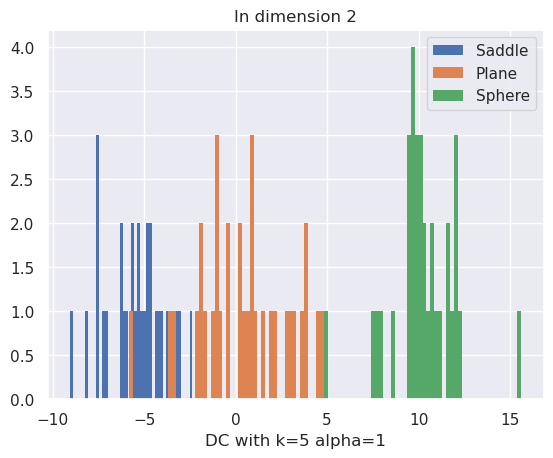

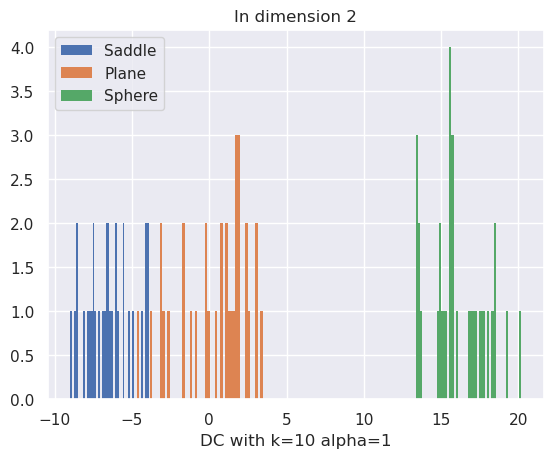

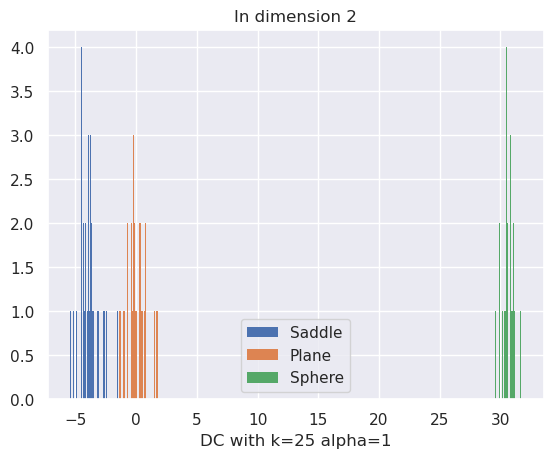

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
DC with k=5 alpha=1,"(0.8377663883518671, 3.107262234835446e-27)",0.464663
DC with k=10 alpha=1,"(0.8298572574242141, 2.55950536163737e-26)",0.467153
DC with k=25 alpha=1,"(0.7283408003942018, 1.3077001090634165e-17)",0.464663


In [8]:
SS.plot()
SS.table()

## Dimension 3

In [ ]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k, t):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, t=t, dim=dim)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=} {t=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [5]:
            for t in [25]:
                tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k, t)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's:   0%|                                                                                                               | 0/99 [00:00<?, ?it/s]2024-03-08 14:15:47,727:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-08 14:15:48,471:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
Processing X's:   1%|█                                                                                                      | 1/99 [00:01<02:15,  1.38s/it]2024-03-08 14:15:49,121:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-08 14:15:49,742:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
Processing X's:   2%|██                                                                                                     | 2/99 [00:02<02:08,  1.33s/it]2024-03-08 14:15:50,436:[WARNING](pygsp.graphs.graph.check_weig

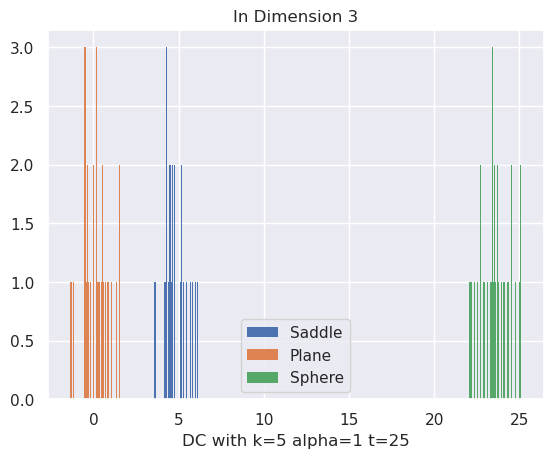

TypeError: descriptor '__weakref__' for 'SadSpheres' objects doesn't apply to a 'SadSpheres' object

In [ ]:
SS.plot(title="In Dimension 3")
SS.table()

In [ ]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 18, # num pointclouds to make in total
    num_points = 8000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k, t):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, t=t, dim=dim)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=} {t=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [5]:
            for t in [25]:
                tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k, t)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's:   0%|                                                                                                               | 0/18 [00:00<?, ?it/s]2024-03-08 15:21:59,409:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-08 15:22:12,573:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
Processing X's:   6%|█████▋                                                                                                 | 1/18 [00:27<07:39, 27.02s/it]2024-03-08 15:22:26,750:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-08 15:22:38,516:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
Processing X's:  11%|███████████▍                                                                                           | 2/18 [00:52<07:00, 26.28s/it]2024-03-08 15:22:52,100:[WARNING](pygsp.graphs.graph.check_weig

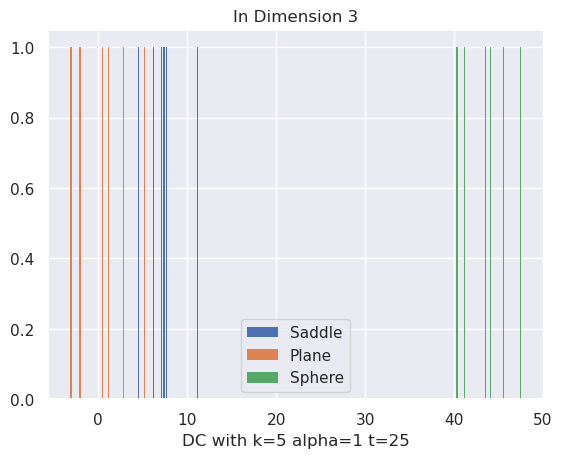

TypeError: descriptor '__weakref__' for 'SadSpheres' objects doesn't apply to a 'SadSpheres' object

In [ ]:
SS.plot(title="In Dimension 3")
SS.table()

## Dimension 4

In [ ]:
import asyncio
from tqdm import trange
dim = 4
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [0, 0.5, 1]:
        for k in [5, 10, 15, 25]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's: 100%|█| 99/99 [14:39<00:00,  8.88s/


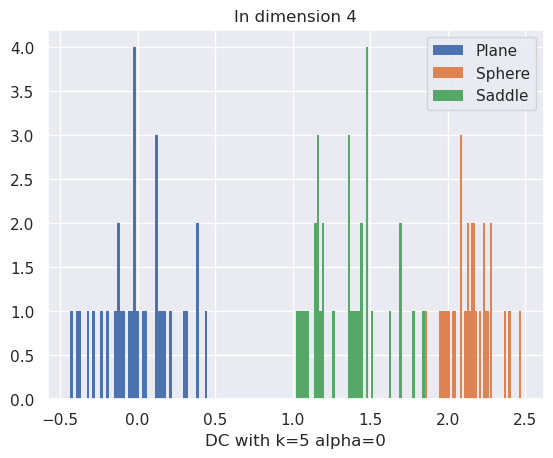

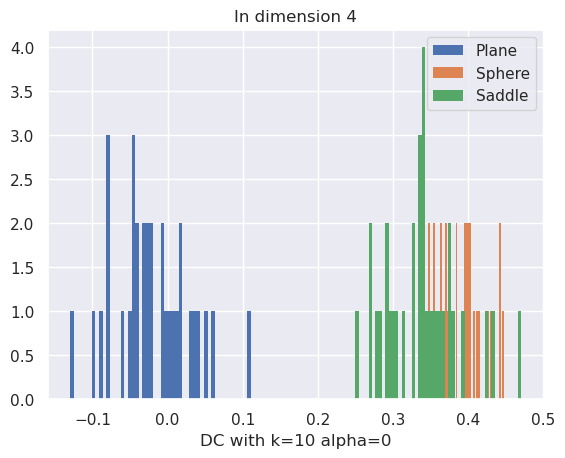

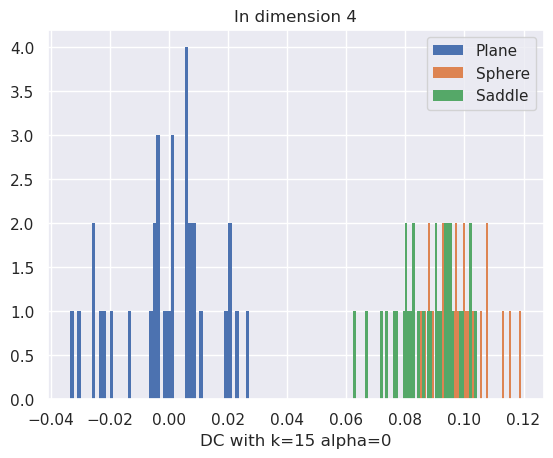

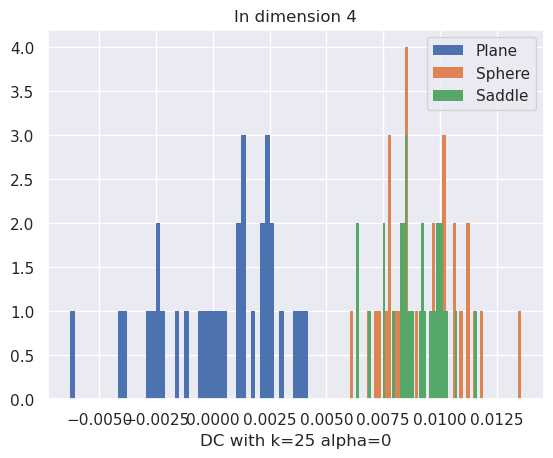

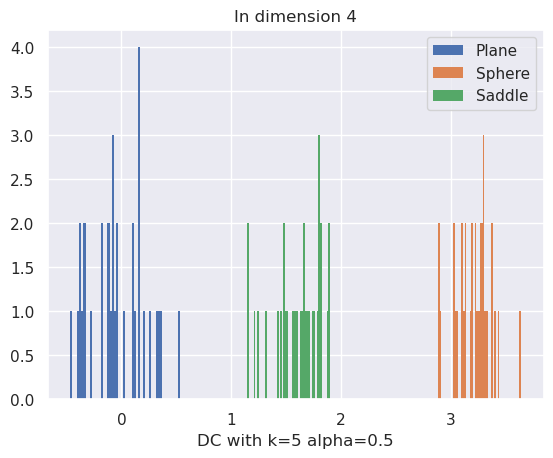

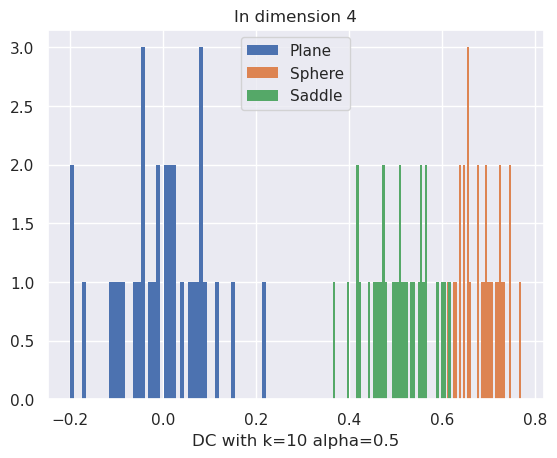

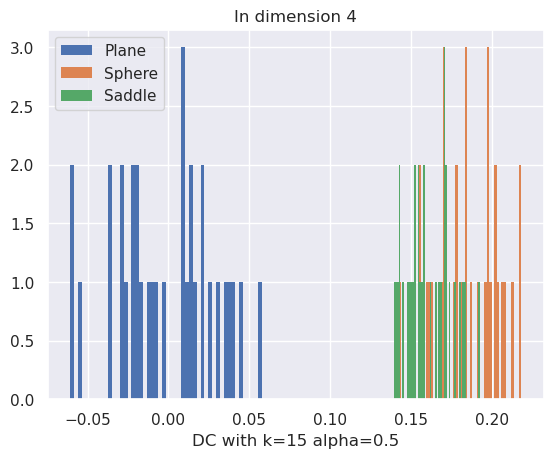

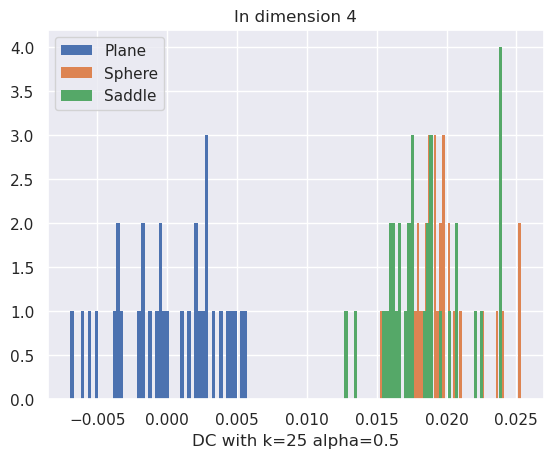

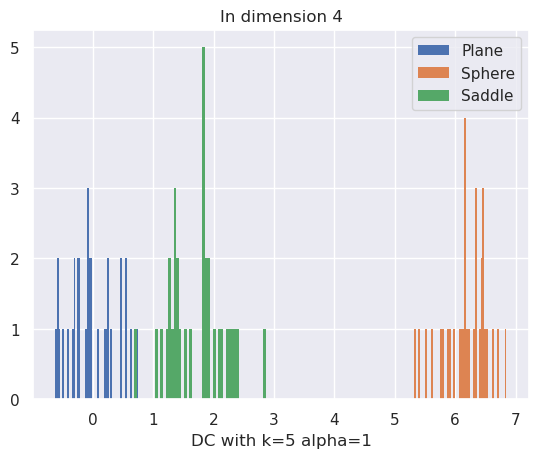

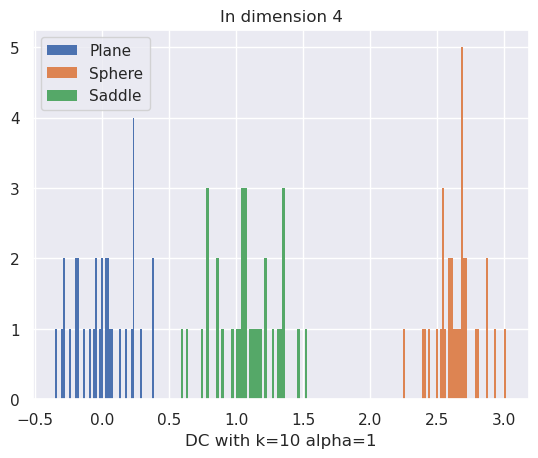

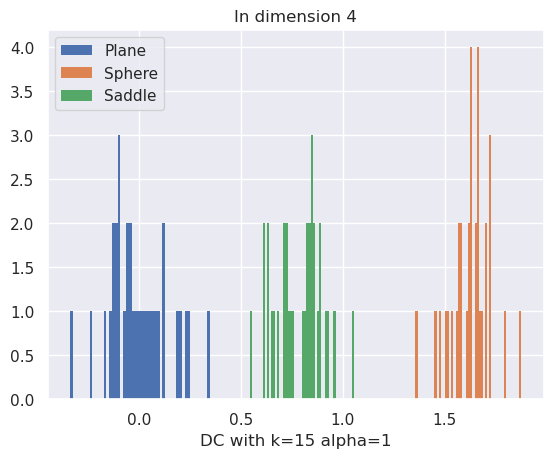

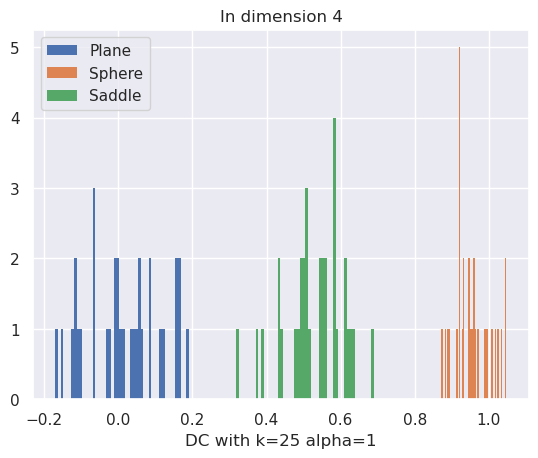

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
DC with k=5 alpha=0,"(-0.04499011999076727, 0.6583554448582754)",0.261786
DC with k=10 alpha=0,"(-0.28908536002322605, 0.003707113948176866)",0.317535
DC with k=15 alpha=0,"(-0.30865419503597136, 0.0018814657194790557)",0.211444
DC with k=25 alpha=0,"(-0.35141322780973505, 0.00036168370688376074)",0.165383
DC with k=5 alpha=0.5,"(0.09450702089794012, 0.35212504851489146)",0.261786
DC with k=10 alpha=0.5,"(-0.17165696995125101, 0.08933638174702259)",0.211444
DC with k=15 alpha=0.5,"(-0.288984708115415, 0.0037196278447960834)",0.227703
DC with k=25 alpha=0.5,"(-0.3461616122401221, 0.00044863764091177606)",0.211444
DC with k=5 alpha=1,"(0.3372264655378036, 0.0006417995761138468)",0.298260


In [ ]:
SS.plot()
SS.table()

# Fixed Kernel with Median Heuristic

## Dimension 2

In [37]:
import asyncio
from tqdm import trange
dim = 2
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

def fixed_median_heuristic_graph_former(X, alpha):
    W = gaussian_kernel(
        X, 
        kernel_type = "fixed",
        sigma = None, # use median heuristic
        anisotropic_density_normalization = alpha,
        threshold_for_small_values = 1e-8,
    )
    # set diagonal of W to zero
    np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G
    
for alpha in [1]:
    for i, X in tqdm(enumerate(SS)):
        graph_former = partial(fixed_median_heuristic_graph_former, alpha = alpha)
        G = graph_former(X)
        DC = DiffusionCurvature(
            laziness_method="Wasserstein",
            flattening_method="Fixed",
            comparison_method="Subtraction",
            graph_former=graph_former,
            points_per_cluster=None,  # construct separate comparison spaces around each point
            comparison_space_size_factor=1,
        )
        ks = DC.curvature(G, dim=dim, t=25)
        SS.update(ks[0], method_name=f"DC with {alpha=}")

0it [00:00, ?it/s]

Task exception was never retrieved
future: <Task finished name='Task-377' coro=<main() done, defined at /tmp/ipykernel_349343/222212053.py:48> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_349343/222212053.py", line 56, in <module>
    asyncio.run(main())
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/nest_asyncio.py", line 36, in run
    loop.run_until_complete(task)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/nest_asyncio.py", line 93, in run_until_complete
    self._run_once()
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/nest_asyncio.py", line 129, in _run_once
    handle._run()
  File "/home/piriac/mambaforge/envs/zetteldev-diffc

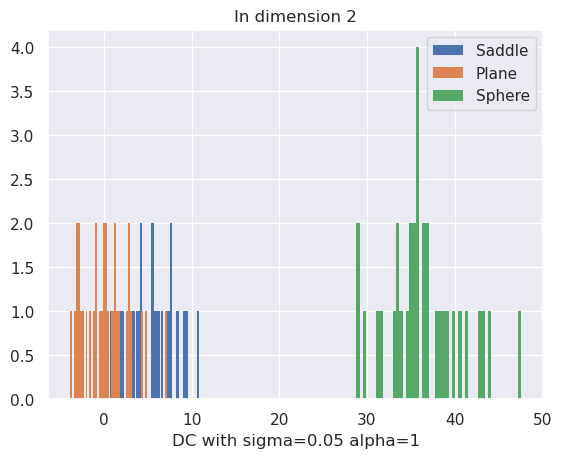

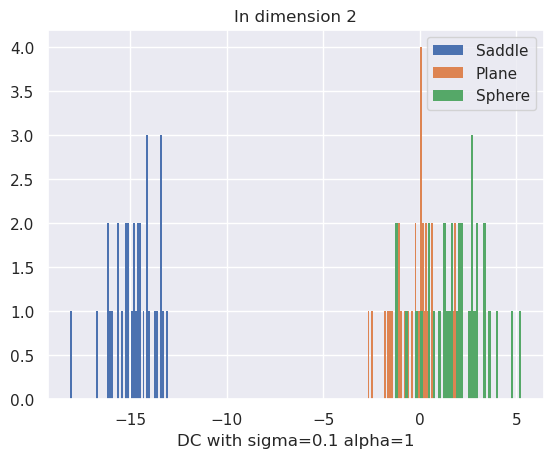

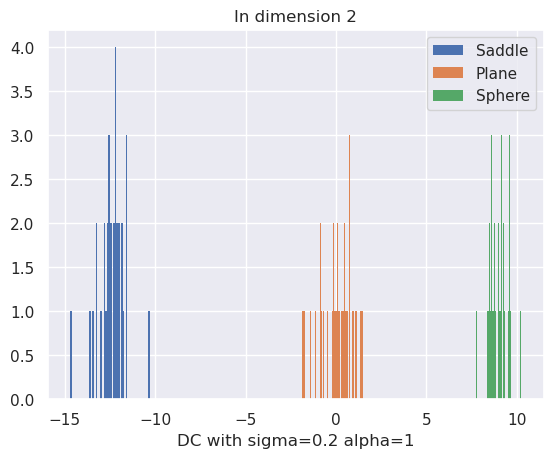

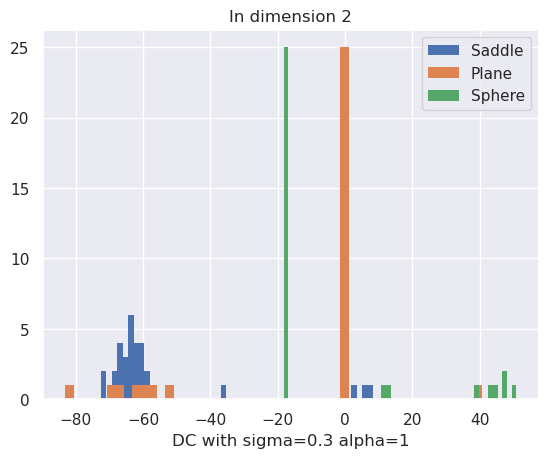

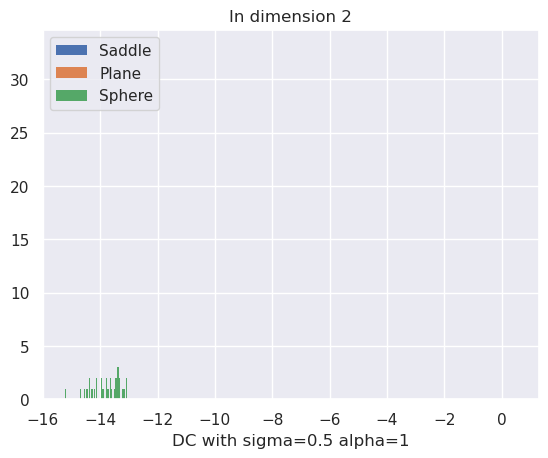

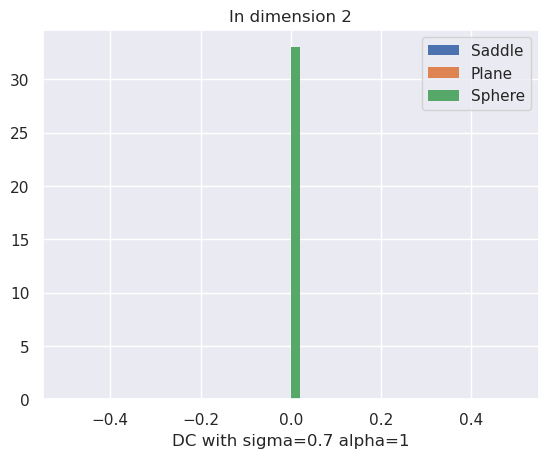

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
DC with sigma=0.05 alpha=1,"(0.5332197922432115, 1.3300509355428774e-08)",0.227703
DC with sigma=0.1 alpha=1,"(0.982713813368596, 7.250616491912024e-73)",0.336638
DC with sigma=0.2 alpha=1,"(0.9688489638176948, 1.3292609130218166e-60)",0.464663
DC with sigma=0.3 alpha=1,"(0.6584964826166031, 1.2857235495770296e-13)",0.395171
DC with sigma=0.5 alpha=1,"(-0.6539817750705643, 2.1439841222909554e-13)",0.636514
DC with sigma=0.7 alpha=1,"(nan, nan)",0.000000


In [66]:
SS.plot()
SS.table()

In [67]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

def fixed_median_heuristic_graph_former(X, alpha):
    W = gaussian_kernel(
        X, 
        kernel_type = "fixed",
        sigma = None, # use median heuristic
        anisotropic_density_normalization = alpha,
        threshold_for_small_values = 1e-8,
    )
    # set diagonal of W to zero
    np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G
    
for alpha in [1]:
    for i, X in tqdm(enumerate(SS)):
        graph_former = partial(fixed_median_heuristic_graph_former, alpha = alpha)
        G = graph_former(X)
        DC = DiffusionCurvature(
            laziness_method="Wasserstein",
            flattening_method="Fixed",
            comparison_method="Subtraction",
            graph_former=graph_former,
            points_per_cluster=None,  # construct separate comparison spaces around each point
            comparison_space_size_factor=1,
        )
        ks = DC.curvature(G, dim=dim, t=25)
        SS.update(ks[0], method_name=f"DC with {alpha=}")

0it [00:00, ?it/s]

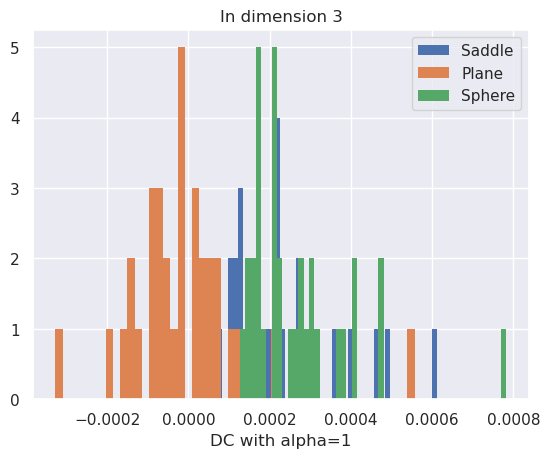

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
DC with alpha=1,"(-0.0738353749799292, 0.467645879662982)",0.247996


In [68]:
SS.plot()
SS.table()

# Fixed Kernel with no Heuristic

## Dimension 2

Here we observe that everything is well separated, and that larger $k$ values separate better, with less noise, as expected.

In [65]:
import asyncio
from tqdm import trange
dim = 2
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

def fixed_graph_former(X, sigma, alpha):
    W = gaussian_kernel(
        X, 
        kernel_type = "fixed",
        sigma = sigma,
        anisotropic_density_normalization = alpha,
    )
    # set diagonal of W to zero
    np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G
    

async def process_alpha_k(X, alpha, sigma):
    global SS
    graph_former = partial(fixed_graph_former, sigma = sigma, alpha = alpha)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {sigma=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for sigma in [0.05, 0.1, 0.2, 0.3, 0.5, 0.7]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, sigma)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's: 100%|██████████| 99/99 [06:53<00:00,  4.18s/it]


In [48]:
SS.plot()
SS.table()

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612


## Dimension 3

In [70]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

def fixed_graph_former(X, sigma, alpha):
    W = gaussian_kernel(
        X, 
        kernel_type = "fixed",
        sigma = sigma,
        anisotropic_density_normalization = alpha,
    )
    # set diagonal of W to zero
    np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G
    

async def process_alpha_k(X, alpha, sigma):
    global SS
    graph_former = partial(fixed_graph_former, sigma = sigma, alpha = alpha)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {sigma=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for sigma in [0.05, 0.1, 0.2, 0.3, 0.5, 0.7]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, sigma)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's: 100%|██████████| 99/99 [07:39<00:00,  4.64s/it]


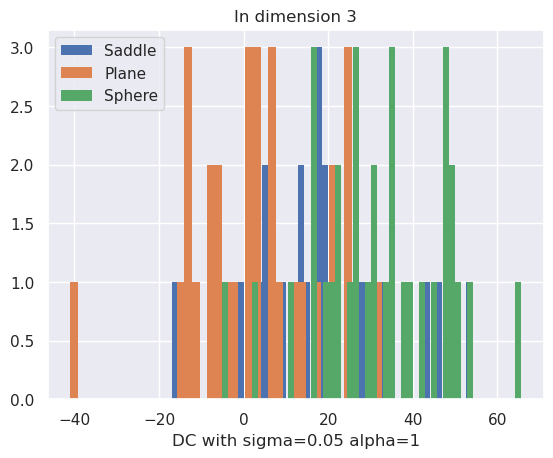

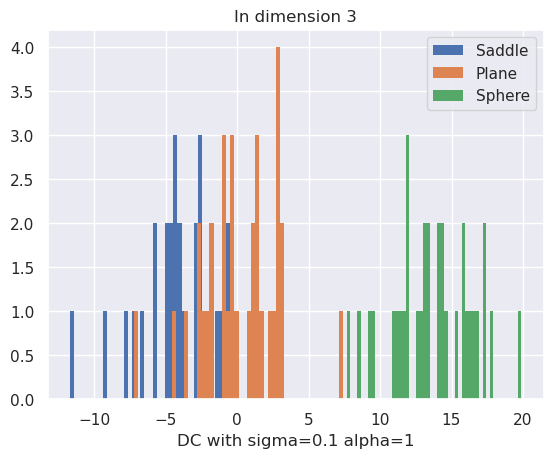

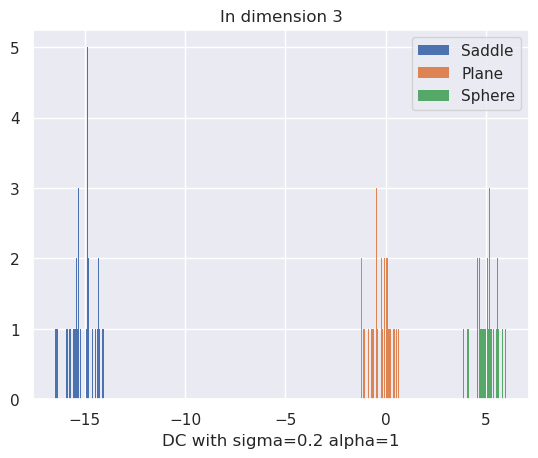

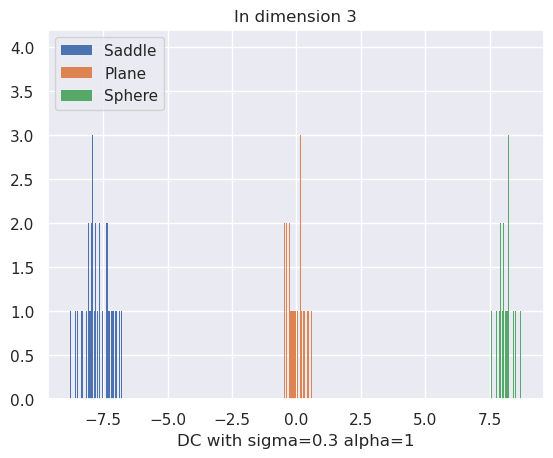

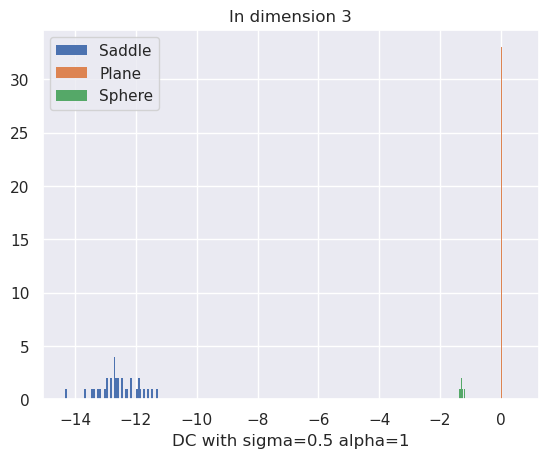

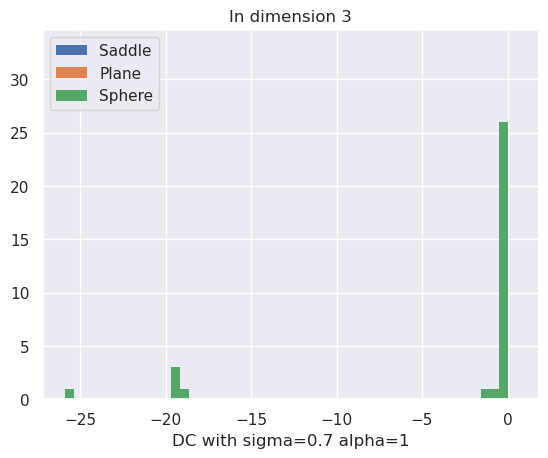

In [71]:
SS.plot()

## Dimension 4

In [72]:
import asyncio
from tqdm import trange
dim = 4
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

def fixed_graph_former(X, sigma, alpha):
    W = gaussian_kernel(
        X, 
        kernel_type = "fixed",
        sigma = sigma,
        anisotropic_density_normalization = alpha,
    )
    # set diagonal of W to zero
    np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G
    

async def process_alpha_k(X, alpha, sigma):
    global SS
    graph_former = partial(fixed_graph_former, sigma = sigma, alpha = alpha)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {sigma=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for sigma in [0.05, 0.1, 0.2, 0.3, 0.5, 0.7]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, sigma)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's: 100%|██████████| 99/99 [08:06<00:00,  4.92s/it]


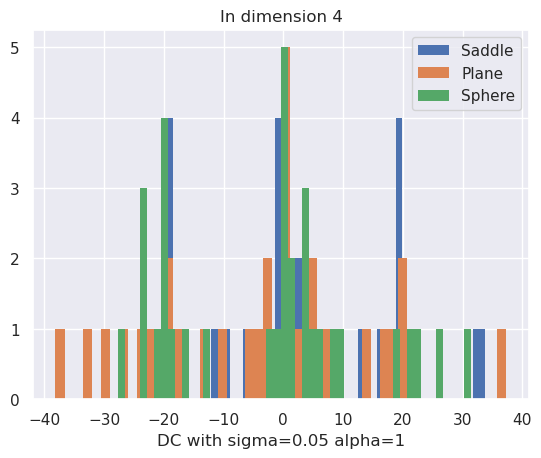

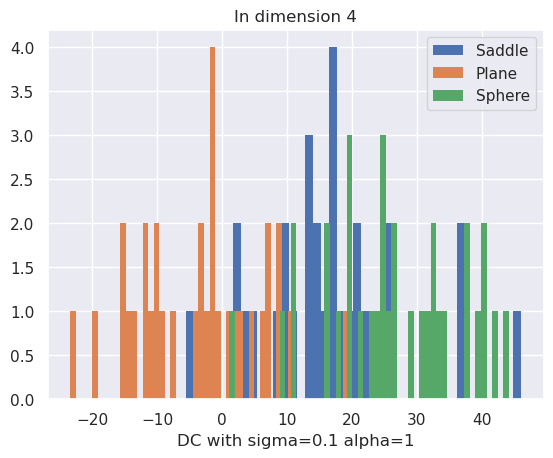

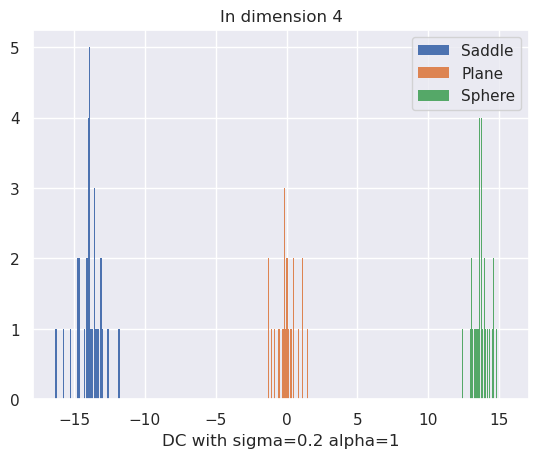

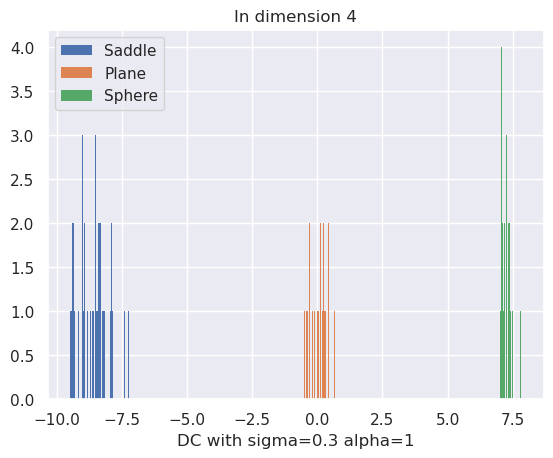

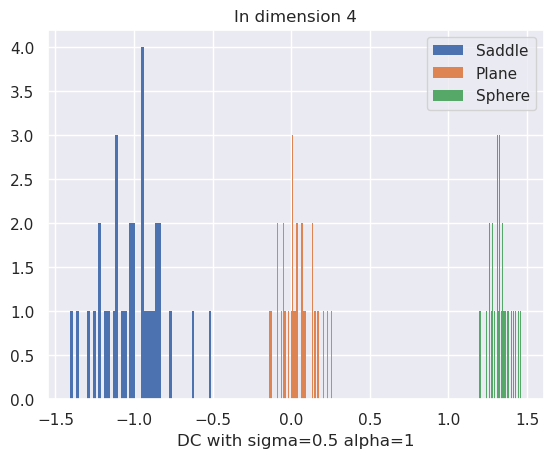

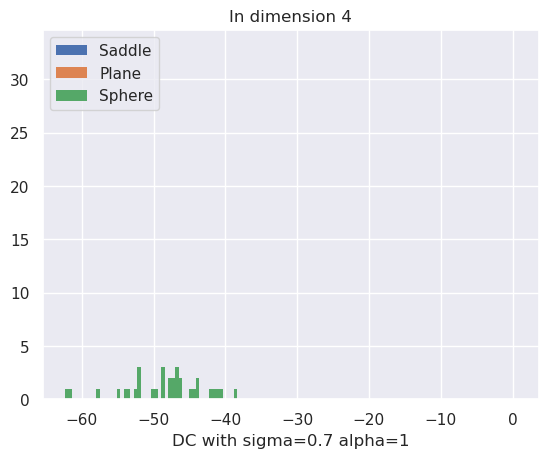

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
DC with sigma=0.05 alpha=1,"(-0.14992713247354766, 0.13855425060009988)",0.005734
DC with sigma=0.1 alpha=1,"(-0.01033868928886673, 0.919102036358564)",0.240504
DC with sigma=0.2 alpha=1,"(0.9108491233086314, 4.652270659229252e-39)",0.462200
DC with sigma=0.3 alpha=1,"(0.9305148066597366, 4.2165457108102737e-44)",0.463018
DC with sigma=0.5 alpha=1,"(0.8797221829177513, 4.40918483160443e-33)",0.480031
DC with sigma=0.7 alpha=1,"(-0.5796093351514864, 3.257235896833858e-10)",0.636514


In [73]:
SS.plot()
SS.table()

## Dimension 5

In [74]:
import asyncio
from tqdm import trange
dim = 5
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

def fixed_graph_former(X, sigma, alpha):
    W = gaussian_kernel(
        X, 
        kernel_type = "fixed",
        sigma = sigma,
        anisotropic_density_normalization = alpha,
    )
    # set diagonal of W to zero
    np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G
    

async def process_alpha_k(X, alpha, sigma):
    global SS
    graph_former = partial(fixed_graph_former, sigma = sigma, alpha = alpha)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {sigma=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for sigma in [0.05, 0.1, 0.2, 0.3, 0.5, 0.7]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, sigma)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's: 100%|██████████| 99/99 [08:42<00:00,  5.27s/it]


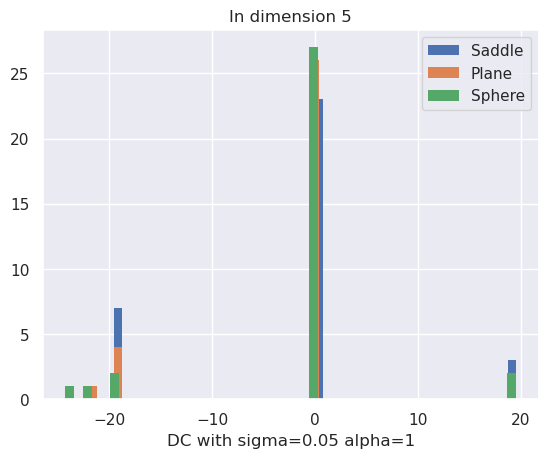

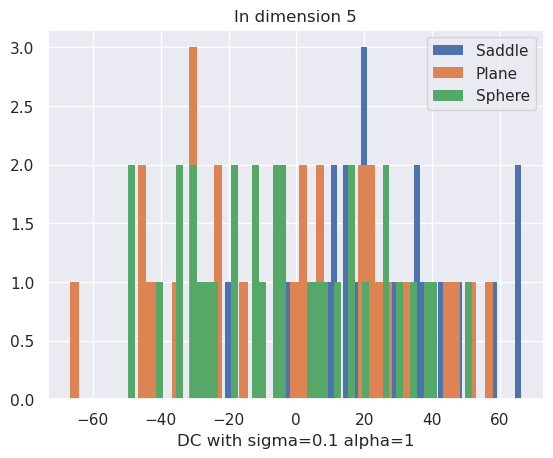

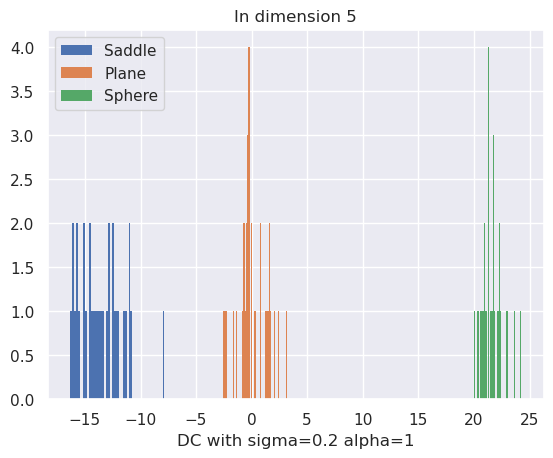

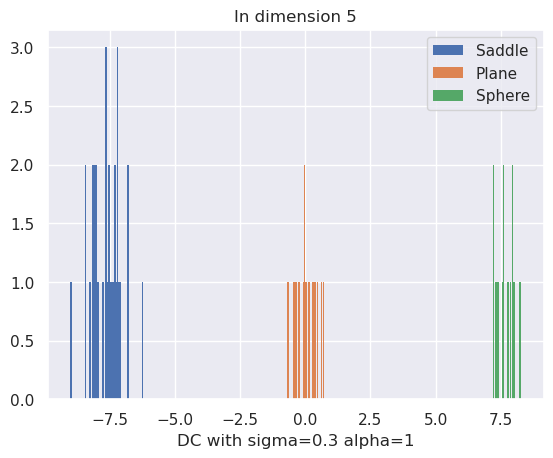

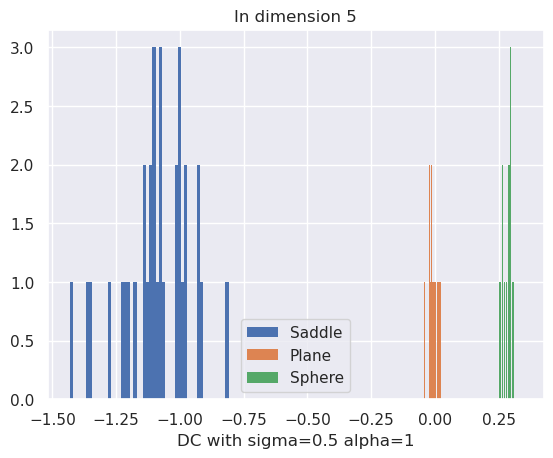

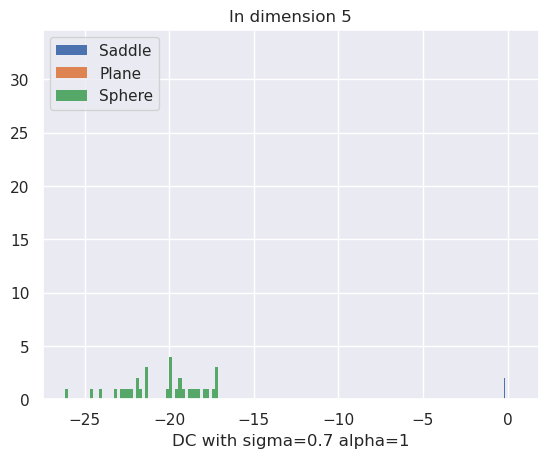

In [75]:
SS.plot()

# Distance Curves

Examining how distance changes with the number of nearest neighbors.

In [52]:
from sklearn.metrics import pairwise_distances

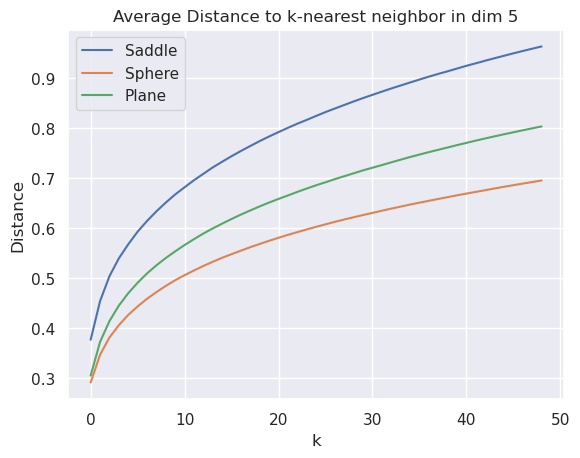

In [64]:
dim = 5
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 3, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)
dnames = {
    0:"Saddle",
    1:"Sphere",
    2:"Plane"
}
for i,X in enumerate(SS):
    D = pairwise_distances(X)
    ds_to_k = []
    for k in np.arange(1,50):
        distance_to_k_neighbor = np.partition(D,k)[:,k]
        ds_to_k.append(np.mean(distance_to_k_neighbor))
    plt.plot(ds_to_k, label=dnames[i])
plt.legend()
plt.xlabel("k")
plt.ylabel("Distance")
plt.title(f"Average Distance to k-nearest neighbor in dim {dim}")
plt.show()

# Entropic Diffusion Curvature with Adaptive Kernel

The entropic definition mirrors the Wasserstein, but with different pathologies in higher dimensions. Here, the relationship between saddles and spheres is reversed: the spheres are assigned lower curvature than the plane, the saddles higher. This effect is strongest with the highest bandwidth kernels, suggesting it involves some extrinsic curvature phenomenon.

## Dimension 2

## Dimension 3

In [ ]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Entropic",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [0, 0.5, 1]:
        for k in [5, 10, 15, 25]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's: 100%|█| 99/99 [08:11<00:00,  4.96s/


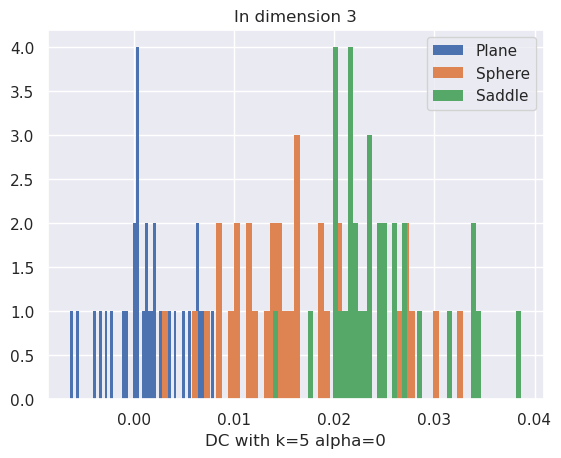

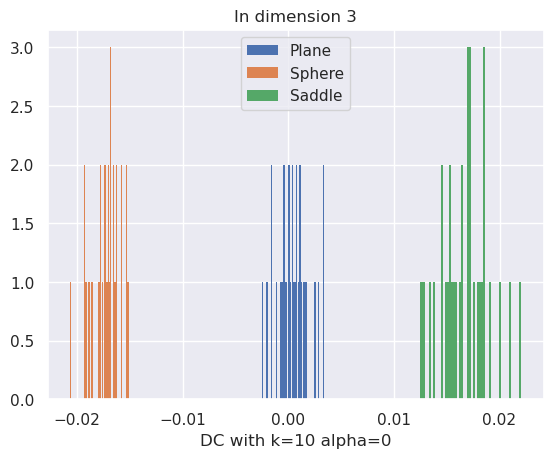

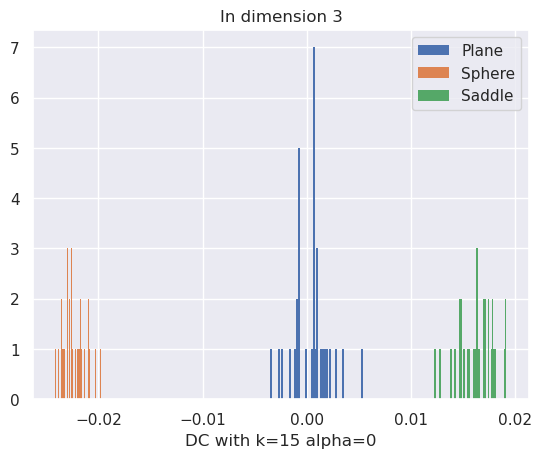

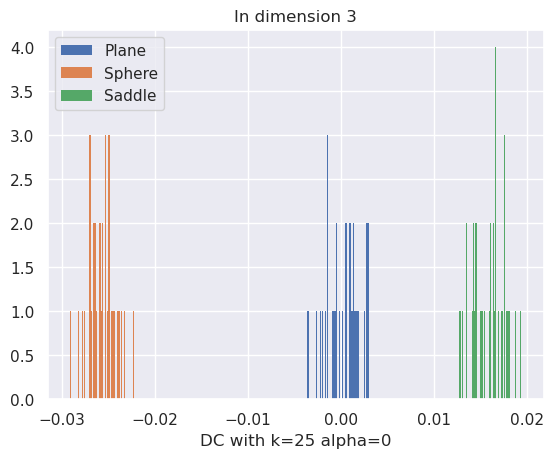

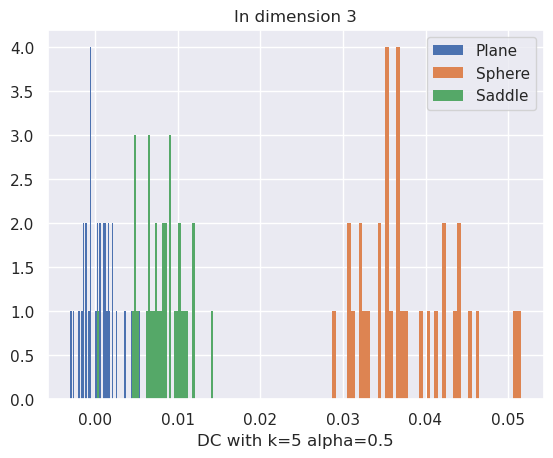

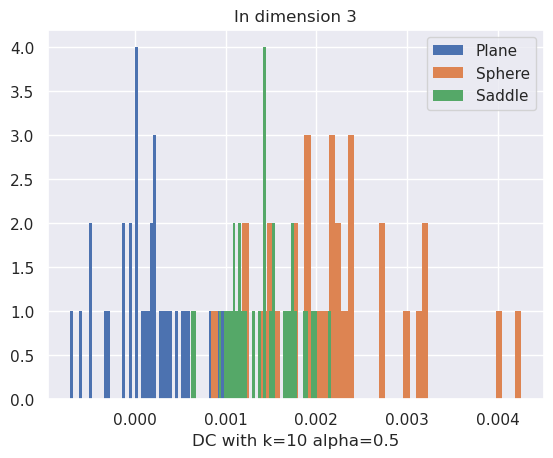

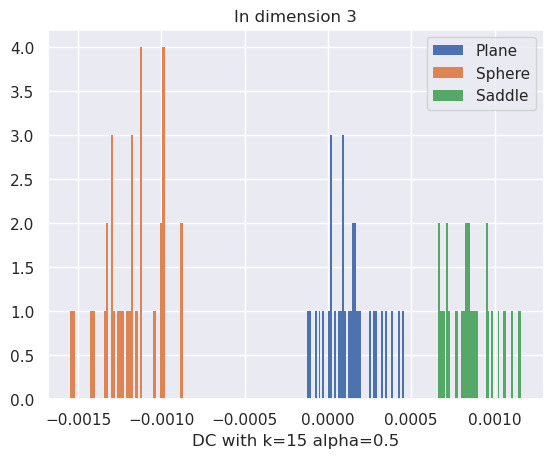

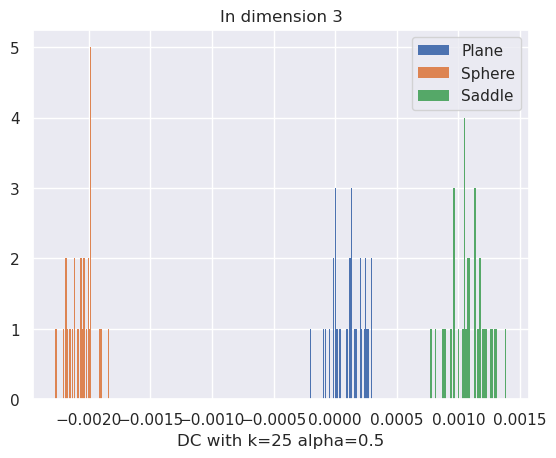

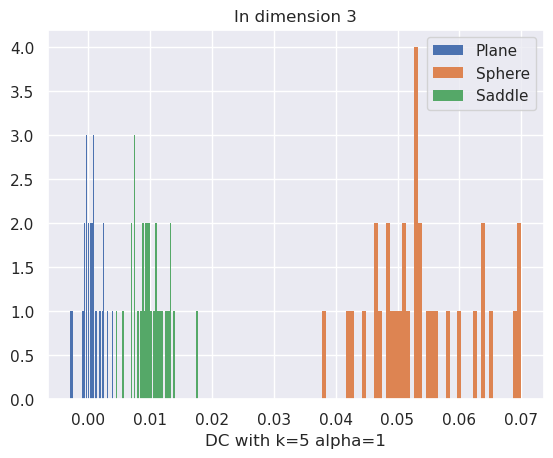

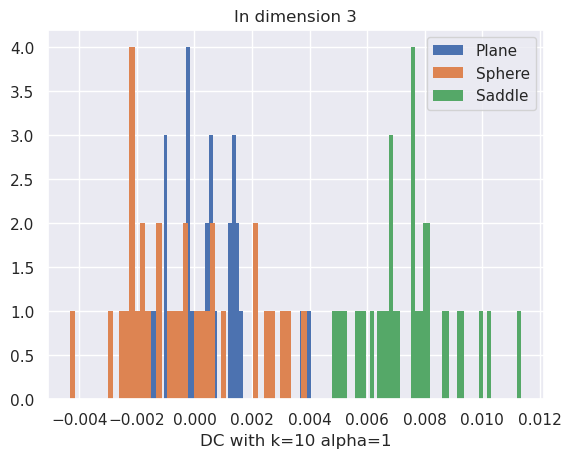

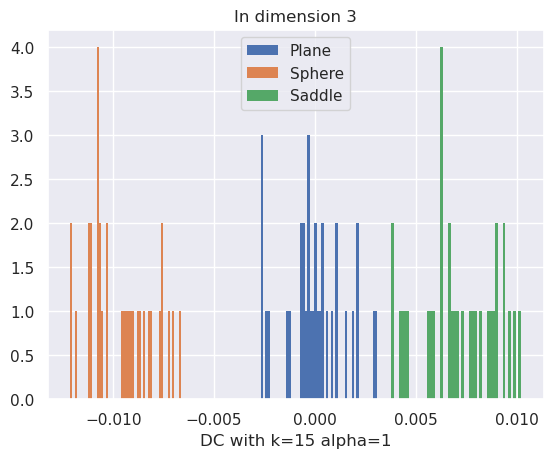

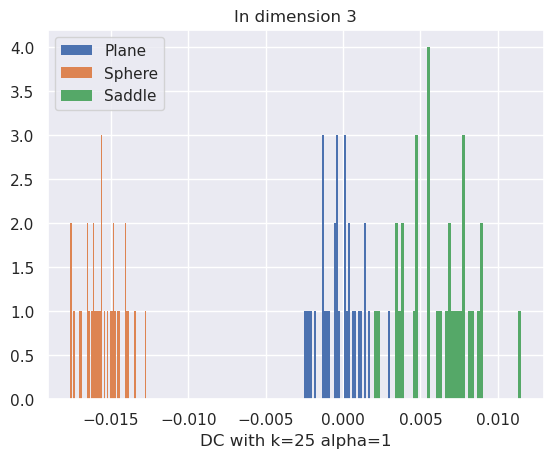

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
DC with k=5 alpha=0,"(-0.5475309723109624, 4.496566719520909e-09)",0.096119
DC with k=10 alpha=0,"(-0.9309605070221104, 3.119422268783093e-44)",0.467153
DC with k=15 alpha=0,"(-0.9027216667563597, 2.626469128719695e-37)",0.467153
DC with k=25 alpha=0,"(-0.885137555990732, 5.395021130490299e-34)",0.464663
DC with k=5 alpha=0.5,"(0.48489127289867345, 3.654308233858701e-07)",0.165383
DC with k=10 alpha=0.5,"(0.04674472654160253, 0.6459121122232154)",0.122827
DC with k=15 alpha=0.5,"(-0.8649174436399509, 8.512376506675884e-31)",0.524136
DC with k=25 alpha=0.5,"(-0.8496585323997602, 1.0441868386021725e-28)",0.512431
DC with k=5 alpha=1,"(0.5058001787313013, 9.278877013045362e-08)",0.150839


In [ ]:
SS.plot()
SS.table()

In [ ]:
import asyncio
from tqdm import trange
dim = 2
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Entropic",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [0, 0.5, 1]:
        for k in [5, 10, 15, 25]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's: 100%|█| 99/99 [08:22<00:00,  5.07s/


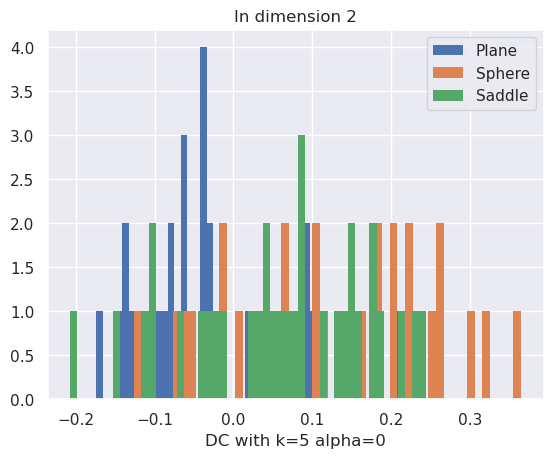

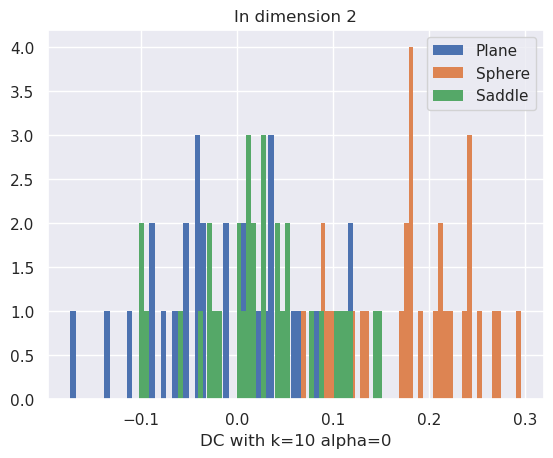

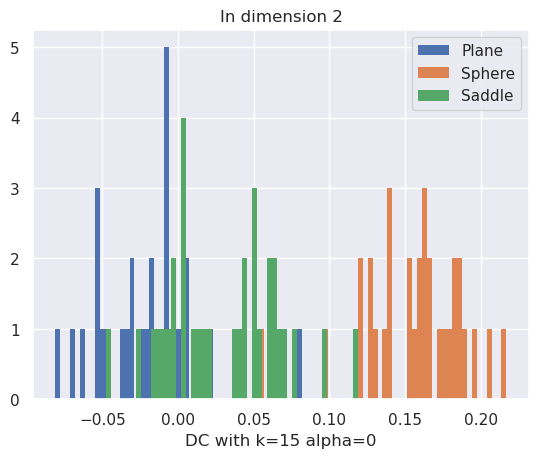

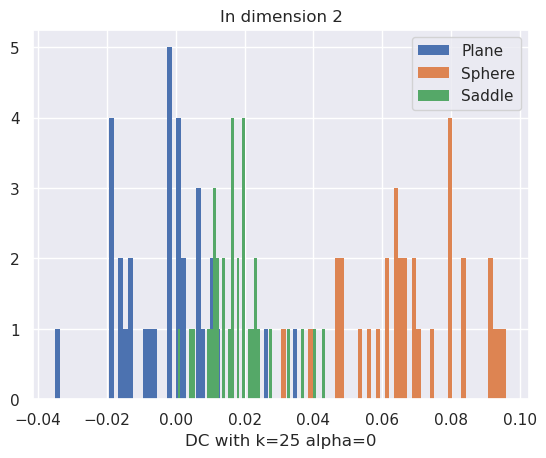

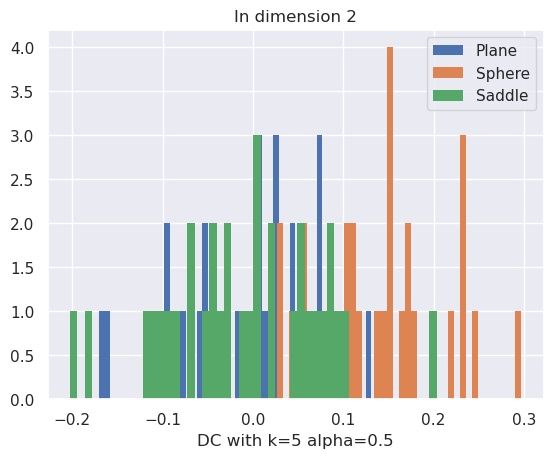

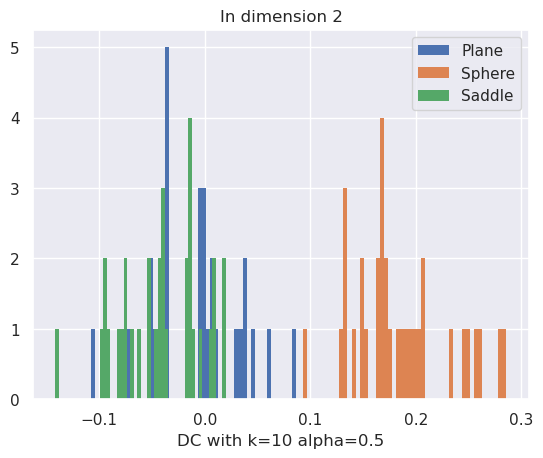

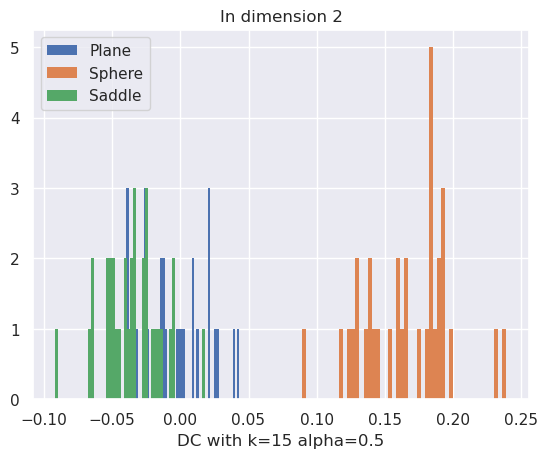

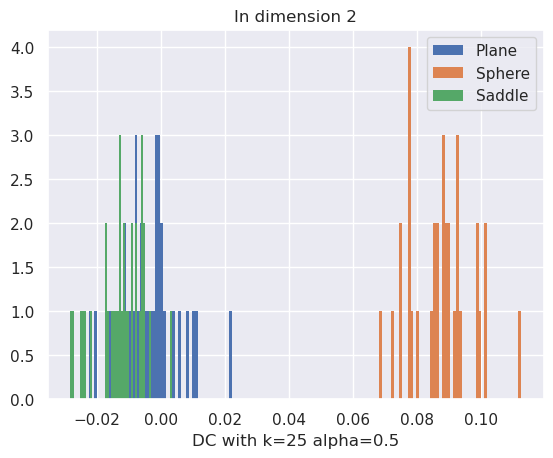

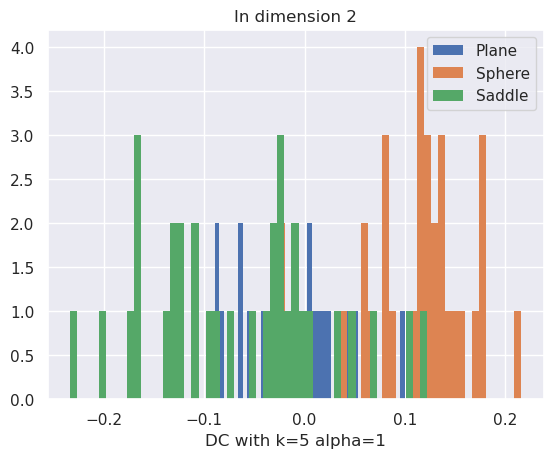

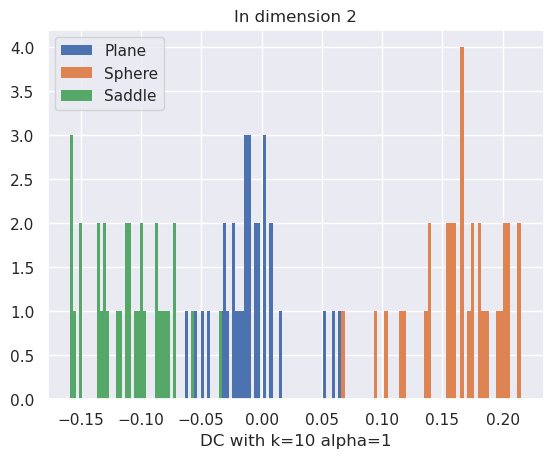

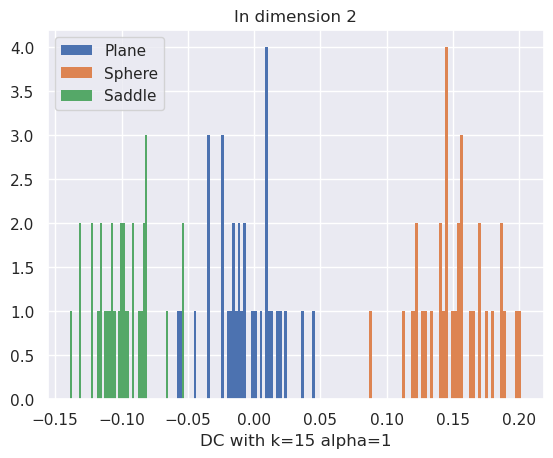

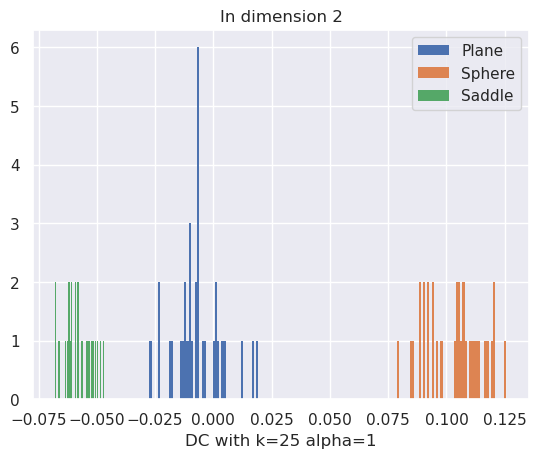

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
DC with k=5 alpha=0,"(0.06968212525117594, 0.49311884824019303)",0.091224
DC with k=10 alpha=0,"(0.38495983086459407, 8.340283621666992e-05)",0.161465
DC with k=15 alpha=0,"(0.39955329265069367, 4.185046709906242e-05)",0.216619
DC with k=25 alpha=0,"(0.370788621368687, 0.00015806401059092584)",0.244470
DC with k=5 alpha=0.5,"(0.40639217679883666, 2.9954875037502023e-05)",0.087497
DC with k=10 alpha=0.5,"(0.6834266486564066, 6.475839412452888e-15)",0.339149
DC with k=15 alpha=0.5,"(0.7162572854886243, 7.805308120168538e-17)",0.426887
DC with k=25 alpha=0.5,"(0.7032316709143906, 4.841583093626817e-16)",0.443918
DC with k=5 alpha=1,"(0.6202828912618967, 7.53462669162706e-12)",0.179818


In [ ]:
SS.plot()
SS.table()

## Dimension 4

In [ ]:
import asyncio
from tqdm import trange
dim = 4
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Entropic",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [0, 0.5, 1]:
        for k in [5, 10, 15, 25]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's: 100%|█| 99/99 [08:03<00:00,  4.88s/


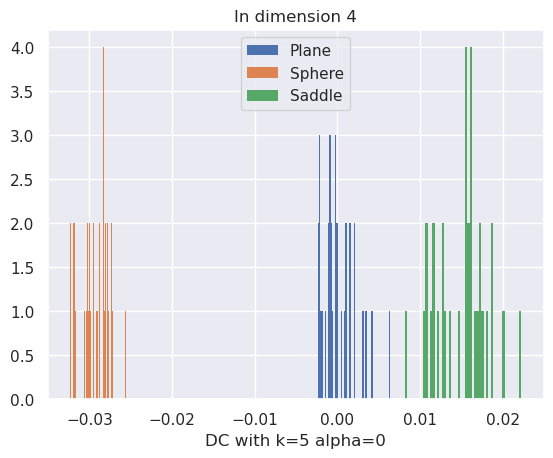

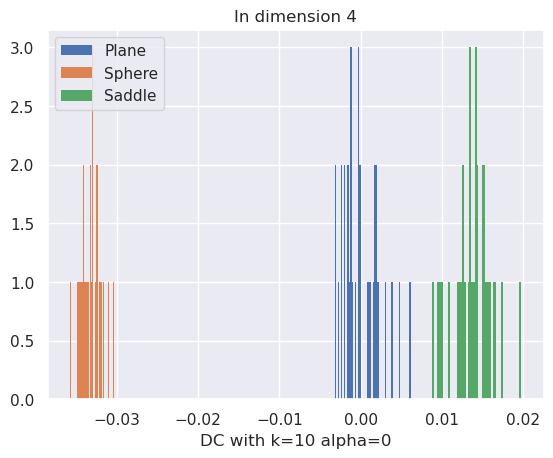

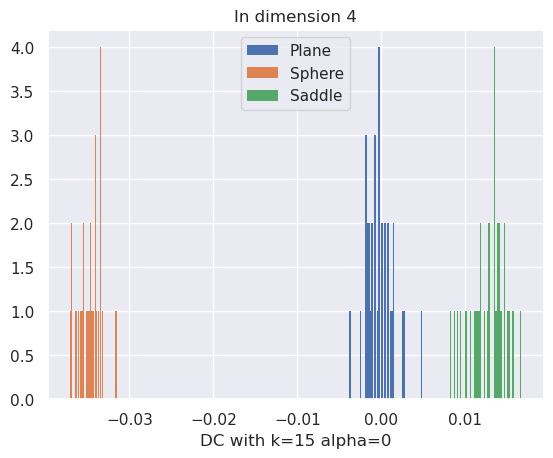

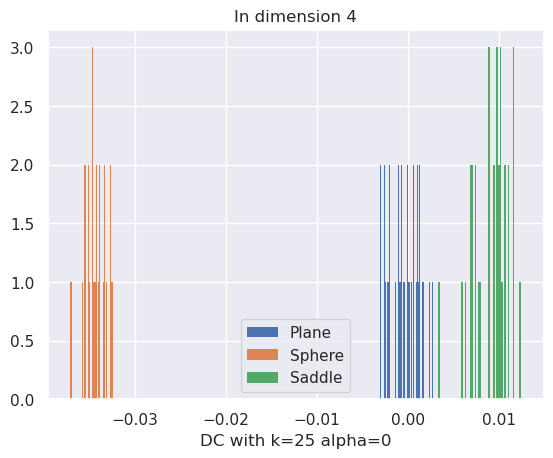

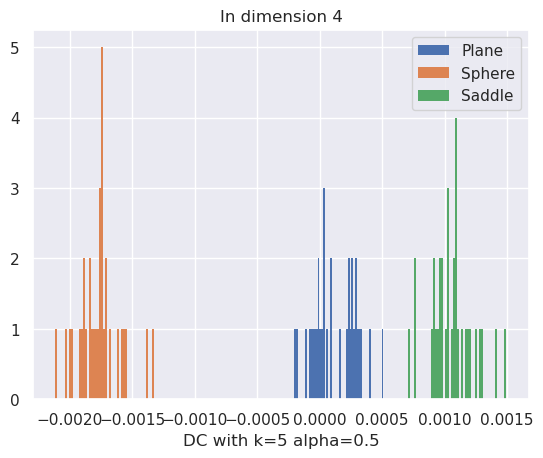

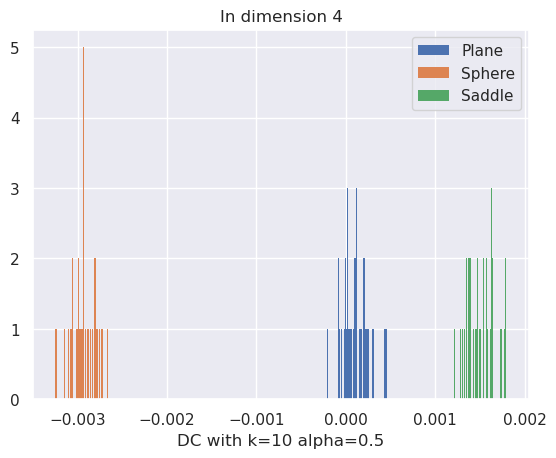

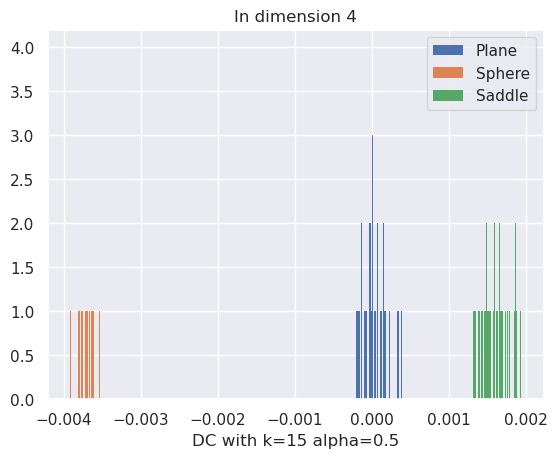

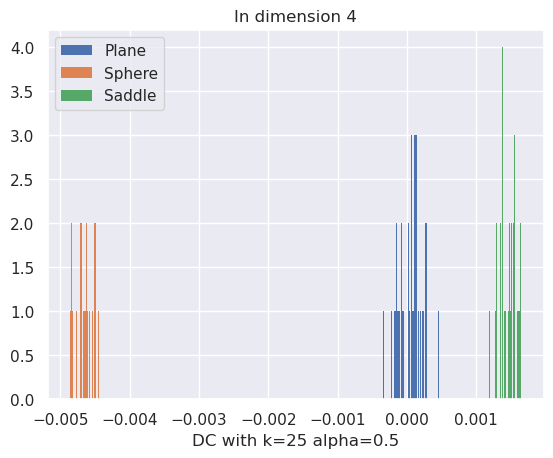

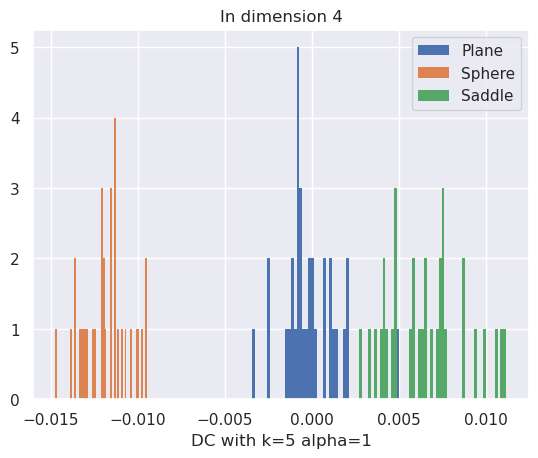

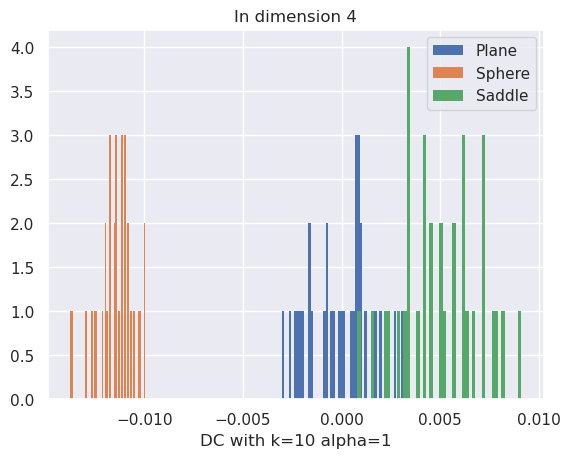

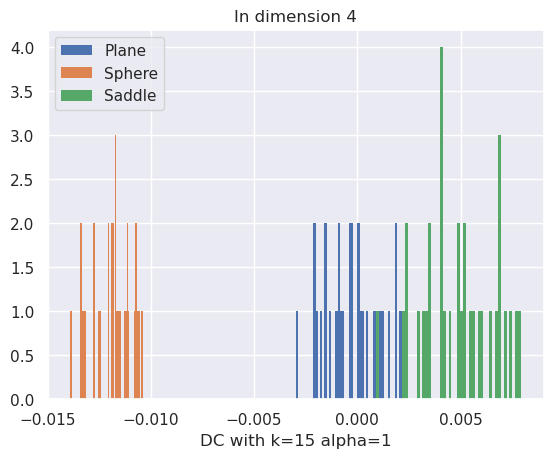

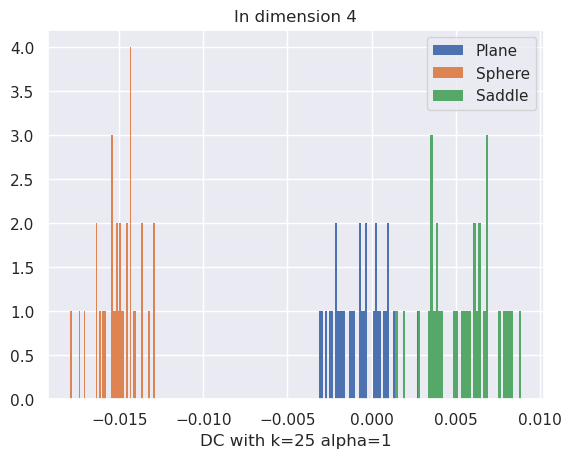

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
DC with k=5 alpha=0,"(-0.8141197717585323, 1.2521345643906124e-24)",0.464663
DC with k=10 alpha=0,"(-0.7858797347024638, 5.769485788004491e-22)",0.467153
DC with k=15 alpha=0,"(-0.7759223875299354, 4.0378641912476086e-21)",0.467153
DC with k=25 alpha=0,"(-0.7373371602964707, 3.246183298225733e-18)",0.462200
DC with k=5 alpha=0.5,"(-0.8098184061536594, 3.4020672348900124e-24)",0.480031
DC with k=10 alpha=0.5,"(-0.806509721698272, 7.214758663852611e-24)",0.493711
DC with k=15 alpha=0.5,"(-0.7913800584009629, 1.882920331143576e-22)",0.464663
DC with k=25 alpha=0.5,"(-0.7481983560909727, 5.584992530648203e-19)",0.470515
DC with k=5 alpha=1,"(-0.8165115965527279, 7.101914138791273e-25)",0.474790


In [ ]:
SS.plot()
SS.table()

# With MIOFlattener

## Dimension 4 - Entropic - MIOFlattener

In [ ]:
import asyncio
from tqdm import trange
dim = 4
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 25, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Entropic",
        flattening_method="MIOFlow",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25, X=X)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [5,10]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's:   0%|       | 0/24 [00:00<?, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


MisconfigurationException: `CUDAAccelerator` can not run on your system since the accelerator is not available. The following accelerator(s) is available and can be passed into `accelerator` argument of `Trainer`: ['cpu'].

In [ ]:
SS.num_pointclouds -= 1

In [ ]:
SS.plot()
SS.table()

## Dimension 4 - Wasserstein - MIOFlattener

In [ ]:
import asyncio
from tqdm import trange
dim = 4
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 25, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="MIOFlow",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25, X=X)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [5]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

SS = 

In [ ]:
SS.num_pointclouds -= 1

In [ ]:
SS.plot()
SS.table()

# ~~~~~ *Intermission* ~~~~~

# How bout tons of points?

*Hypothesis:* The pathologies encountered above are caused by the *sparsity* of higher dimensions. Here we increase the number of points per pointcloud from 2000 to 10000.

## Dimension 2

In [ ]:
import asyncio
from tqdm import trange
dim = 2
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 12, # num pointclouds to make in total
    num_points = 10000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k):
    global SS
    X = jax.device_put(X)
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
        verbose=True
    )
    ks = DC.curvature(G, dim=dim, t=80)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [15,]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())


Processing X's:   0%|                                                                                                               | 0/12 [00:00<?, ?it/s]

Manifold spreads are [154.6579   104.48163   85.714554 ...  90.30353  132.68793   92.566986]
average_dim_in_cluster=2
comparison entropy is 147.5979461669922
Manifold spreads are [168.08324  108.97592   90.68477  ...  95.980286 140.18535   99.90057 ]
average_dim_in_cluster=2
comparison entropy is 156.99942016601562
Manifold spreads are [173.5497  111.22987  94.39894 ...  99.74249 143.73453 103.94037]
average_dim_in_cluster=2
comparison entropy is 162.2052001953125
Manifold spreads are [176.14034 112.67741  97.056   ... 102.21626 145.58432 106.18776]
average_dim_in_cluster=2



Processing X's:   8%|████████▌                                                                                             | 1/12 [02:47<30:44, 167.70s/it]

comparison entropy is 165.89346313476562
Manifold spreads are [130.68124 132.24228 130.8274  ... 132.43533 132.68524 132.21368]
average_dim_in_cluster=2
comparison entropy is 144.19113159179688
Manifold spreads are [139.35522 140.33041 140.05307 ... 140.5632  141.0602  140.59686]
average_dim_in_cluster=2
comparison entropy is 156.487060546875
Manifold spreads are [142.63971 143.27347 143.70917 ... 143.61871 143.9732  143.93727]
average_dim_in_cluster=2
comparison entropy is 163.12310791015625
Manifold spreads are [143.23936 143.7536  144.11426 ... 144.05832 144.20764 144.46365]
average_dim_in_cluster=2



Processing X's:  17%|█████████████████                                                                                     | 2/12 [05:36<28:02, 168.27s/it]

comparison entropy is 165.1611328125
Manifold spreads are [145.29568   96.43381   67.48709  ... 108.080505 100.007065  68.07948 ]
average_dim_in_cluster=2
comparison entropy is 148.7581787109375
Manifold spreads are [156.93118 104.75905  75.41973 ... 113.83476 108.25068  74.78293]
average_dim_in_cluster=2
comparison entropy is 157.5262451171875
Manifold spreads are [161.14677  109.322464  80.367516 ... 116.873215 112.52196   79.13306 ]
average_dim_in_cluster=2
comparison entropy is 162.59732055664062
Manifold spreads are [163.35919  111.8055    83.45949  ... 118.97672  115.14485   82.056335]
average_dim_in_cluster=2



Processing X's:  25%|█████████████████████████▌                                                                            | 3/12 [08:30<25:39, 171.00s/it]

comparison entropy is 164.31866455078125
Manifold spreads are [155.51828  123.25311   88.90738  ... 138.90053   87.608505  92.59345 ]
average_dim_in_cluster=2
comparison entropy is 144.645263671875
Manifold spreads are [168.55568 129.44594  96.49194 ... 147.85503  95.29805  99.58923]
average_dim_in_cluster=2
comparison entropy is 158.0756378173828
Manifold spreads are [173.34586 132.13522 101.07276 ... 151.85028 100.35485 103.7042 ]
average_dim_in_cluster=2


2024-03-07 14:28:17.184102: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.12GiB (rounded to 1200001024)requested by op 
2024-03-07 14:28:17.184270: W external/tsl/tsl/framework/bfc_allocator.cc:497] *******_*************************************************______************************************_
2024-03-07 14:28:17.184415: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1200000896 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  381.47MiB
              constant allocation:         0B
        maybe_live_out allocation:  381.47MiB
     preallocated temp allocation:    1.12GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    1.86GiB
              total fragmentation:  377.47MiB (19.79%)
Peak buffers:
	Buffer 1:
		Size: 381.47MiB

ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1200000896 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  381.47MiB
              constant allocation:         0B
        maybe_live_out allocation:  381.47MiB
     preallocated temp allocation:    1.12GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    1.86GiB
              total fragmentation:  377.47MiB (19.79%)
Peak buffers:
	Buffer 1:
		Size: 381.47MiB
		Operator: op_name="jit(matrix_power)/jit(main)/dot_general[dimension_numbers=(((1,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/src/diffusion_curvature/heat_diffusion.py" source_line=16
		XLA Label: custom-call
		Shape: f32[10000,10000]
		==========================

	Buffer 2:
		Size: 381.47MiB
		Operator: op_name="jit(matrix_power)/jit(main)/dot_general[dimension_numbers=(((1,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/src/diffusion_curvature/heat_diffusion.py" source_line=16
		XLA Label: custom-call
		Shape: f32[10000,10000]
		==========================

	Buffer 3:
		Size: 381.47MiB
		Operator: op_name="jit(matrix_power)/jit(main)/dot_general[dimension_numbers=(((1,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/src/diffusion_curvature/heat_diffusion.py" source_line=16
		XLA Label: custom-call
		Shape: f32[10000,10000]
		==========================

	Buffer 4:
		Size: 381.47MiB
		Entry Parameter Subshape: f32[10000,10000]
		==========================

	Buffer 5:
		Size: 381.47MiB
		Operator: op_name="jit(matrix_power)/jit(main)/dot_general[dimension_numbers=(((1,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/src/diffusion_curvature/heat_diffusion.py" source_line=16
		XLA Label: custom-call
		Shape: f32[10000,10000]
		==========================

	Buffer 6:
		Size: 16B
		Operator: op_name="jit(matrix_power)/jit(main)/dot_general[dimension_numbers=(((1,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/src/diffusion_curvature/heat_diffusion.py" source_line=16
		XLA Label: custom-call
		Shape: (f32[10000,10000], s8[4194304])
		==========================

	Buffer 7:
		Size: 16B
		Operator: op_name="jit(matrix_power)/jit(main)/dot_general[dimension_numbers=(((1,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/src/diffusion_curvature/heat_diffusion.py" source_line=16
		XLA Label: custom-call
		Shape: (f32[10000,10000], s8[4194304])
		==========================

	Buffer 8:
		Size: 16B
		Operator: op_name="jit(matrix_power)/jit(main)/dot_general[dimension_numbers=(((1,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/src/diffusion_curvature/heat_diffusion.py" source_line=16
		XLA Label: custom-call
		Shape: (f32[10000,10000], s8[4194304])
		==========================

	Buffer 9:
		Size: 16B
		Operator: op_name="jit(matrix_power)/jit(main)/dot_general[dimension_numbers=(((1,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/src/diffusion_curvature/heat_diffusion.py" source_line=16
		XLA Label: custom-call
		Shape: (f32[10000,10000], s8[4194304])
		==========================

	Buffer 10:
		Size: 16B
		Operator: op_name="jit(matrix_power)/jit(main)/dot_general[dimension_numbers=(((1,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/src/diffusion_curvature/heat_diffusion.py" source_line=16
		XLA Label: custom-call
		Shape: (f32[10000,10000], s8[4194304])
		==========================

	Buffer 11:
		Size: 16B
		Operator: op_name="jit(matrix_power)/jit(main)/dot_general[dimension_numbers=(((1,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/src/diffusion_curvature/heat_diffusion.py" source_line=16
		XLA Label: custom-call
		Shape: (f32[10000,10000], s8[4194304])
		==========================

	Buffer 12:
		Size: 16B
		Operator: op_name="jit(matrix_power)/jit(main)/dot_general[dimension_numbers=(((1,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/src/diffusion_curvature/heat_diffusion.py" source_line=16
		XLA Label: custom-call
		Shape: (f32[10000,10000], s8[4194304])
		==========================



In [ ]:
SS.plot()
SS.table()

## Dimension 3

In [ ]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 10000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [5]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())


Processing X's:   0%|       | 0/99 [00:00<?, ?it/s]
Processing X's:   1%| | 1/99 [01:26<2:21:23, 86.56s


KeyboardInterrupt: 

In [ ]:
SS.plot()
SS.table()

## Dimension 4

In [ ]:
import asyncio
from tqdm import trange
dim = 4
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 10000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [5]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

In [ ]:
SS.plot()
SS.table()

# Normalization by Jump

## Dimension 3

In [ ]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 20, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k, t):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein Normalized",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.unsigned_curvature(G, t=t)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=} {t=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [5, 10, 25]:
            for t in [25,35,50]:
                tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k, t)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())


Processing X's: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:49<00:00,  2.74s/it]


[autoreload of diffusion_curvature.flattening.mioflow failed: Traceback (most recent call last):
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_gener

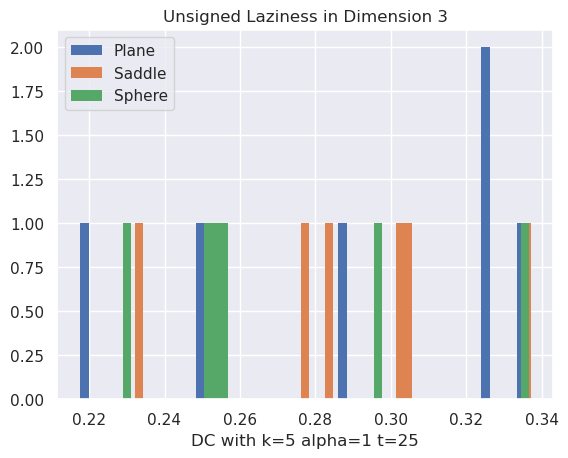

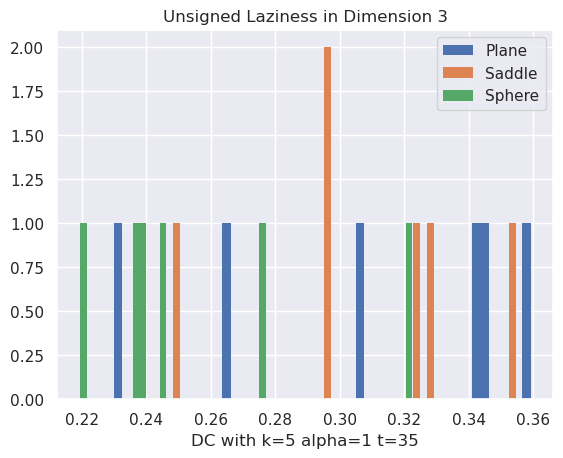

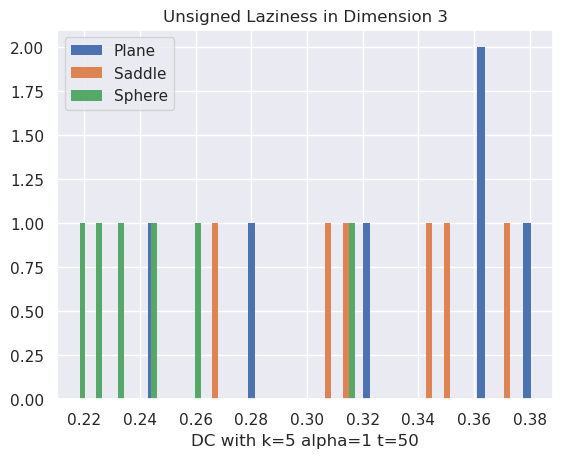

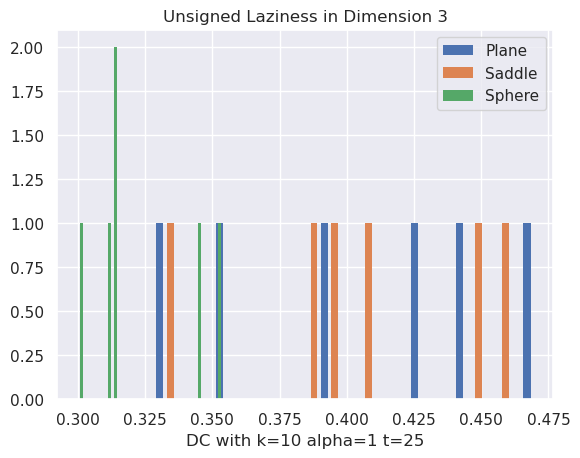

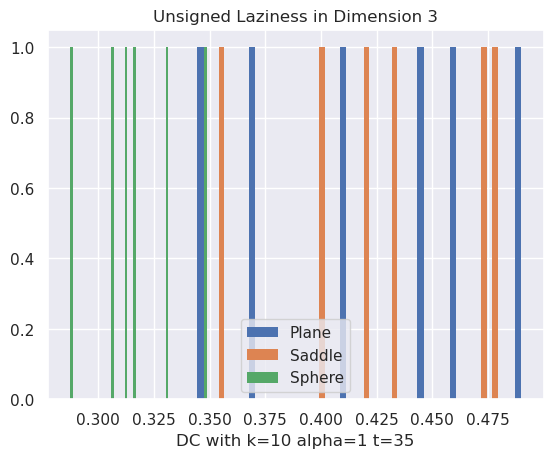

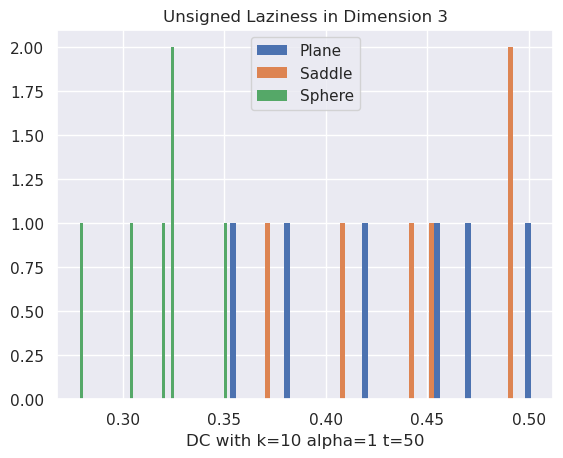

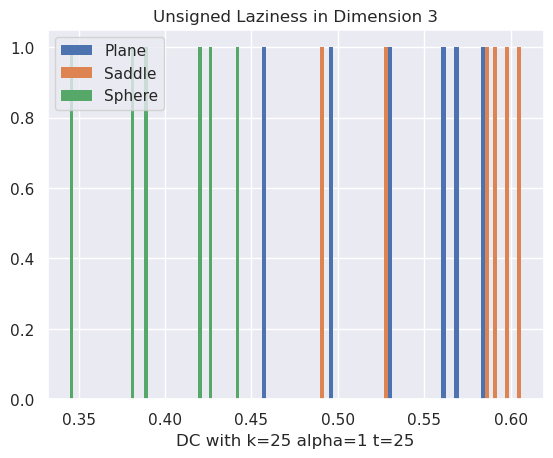

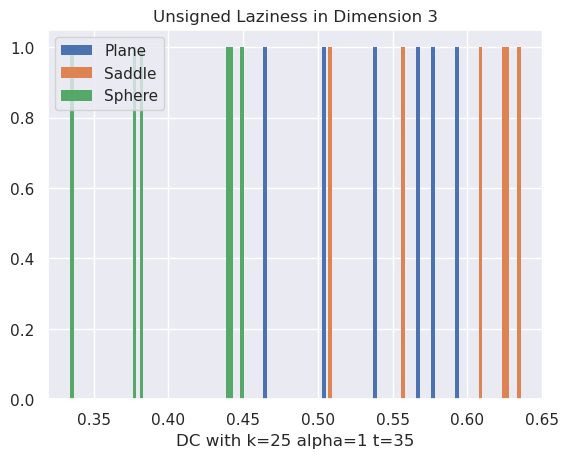

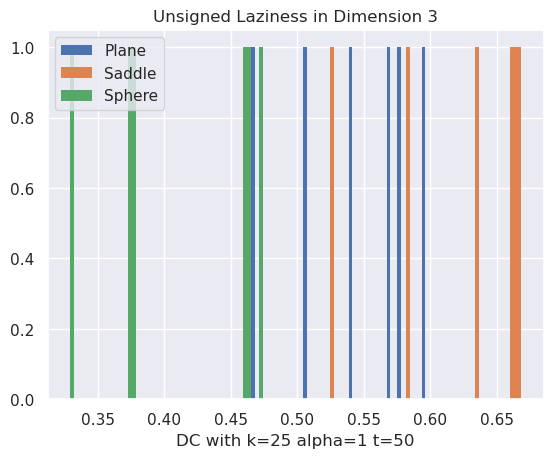

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
DC with k=5 alpha=1 t=25,"(-0.15618132789153166, 0.5360035904217212)",0.000000
DC with k=5 alpha=1 t=35,"(-0.3449775876079314, 0.16090840804812936)",0.000000
DC with k=5 alpha=1 t=50,"(-0.4420083560985159, 0.06627232959924967)",0.000000
DC with k=10 alpha=1 t=25,"(-0.48047749776639825, 0.043562977872826446)",0.000000
DC with k=10 alpha=1 t=35,"(-0.5459222785416096, 0.019093086849561416)",0.000000
DC with k=10 alpha=1 t=50,"(-0.5860626390697085, 0.010589653894437726)",0.000000
DC with k=25 alpha=1 t=25,"(-0.6856599525764792, 0.0016834326520362786)",0.000000
DC with k=25 alpha=1 t=35,"(-0.7276780176452887, 0.0006195138310503194)",0.000000
DC with k=25 alpha=1 t=50,"(-0.7692244641160857, 0.00019028519732217338)",0.000000


In [ ]:
SS.plot(title="Unsigned Laziness in Dimension 3")
SS.table()

# Conclusion